<a href="https://colab.research.google.com/github/FinNijatTech/ML-algorithms-as-EWM-for-Economic-Crisis/blob/main/Master_Thesis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import statsmodels as sm

In [260]:
df = pd.read_excel("/content/Master_Thesis_Data Experiment Data Cutting without crisis (No IR).xlsx")
df

,Country,Date,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,Share Price,International Investment
0,DE,1970-Q1,0,NaN,31.535927,-1.595662,2.894135,9.536667,-1.991301,NaN,7.833333,NaN,10.873150,NaN
1,DE,1970-Q2,0,NaN,32.363393,3.975818,3.335860,9.890000,8.214446,NaN,8.400000,NaN,9.807037,NaN
2,DE,1970-Q3,0,NaN,33.204478,1.867836,3.566009,9.370000,5.363654,NaN,8.533334,NaN,9.271091,NaN
3,DE,1970-Q4,0,85.6,34.062502,0.847607,4.000000,8.830000,-0.028774,NaN,8.500000,NaN,8.835394,NaN
4,DE,1971-Q1,0,85.8,34.907015,-1.921103,4.441154,7.476666,-1.492452,NaN,7.766667,NaN,9.699077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,CA,2018-Q4,0,216.2,129.660633,0.340870,2.035623,2.112573,-1.296769,-2.919957,2.318050,5.700000,104.797200,464071.9
2596,CA,2019-Q1,0,217.0,129.556938,0.070759,1.611685,1.997995,1.606348,-3.080937,1.857795,5.800000,109.103100,440252.9
2597,CA,2019-Q2,0,219.3,128.061840,0.988110,2.148389,1.859268,0.004727,-1.128215,1.616548,5.566667,114.186500,430767.2
2598,CA,2019-Q3,0,221.0,129.734163,0.374027,1.939334,1.837570,2.206205,-2.178369,1.362776,5.733333,114.896600,426274.6


In [261]:
# MB: I would only fill in NA values where there are missing in-between data
#df.ffill(inplace=True) # filling NA values
#df.bfill(inplace=True) # filling NA values
#df

#df.fillna(0, inplace=True)


In [262]:
df['Share Price Growth'] = df['Share Price'].pct_change() * 100
df['Housing Price Growth'] = df['Housing price'].pct_change() * 100
df = df.drop(columns = ['Share Price', 'Housing price'])

In [263]:
# Consider some limited interactions, like high credit to GDP and high interest rates

df['C-GDP/3MMR_dummy'] = ((df['Credit to GDP'] > df['Credit to GDP'].mean()) & (df['3 month money market rate'] > df['3 month money market rate'].mean()))
df['C-GDP/3MMR_dummy'] = df['C-GDP/3MMR_dummy'].astype(int)

df['GDP/UER_dummy'] = ((df['GDP growth'] < 0) & (df['Unemployment'] > df['Unemployment'].mean())).astype(int)

df['INF/10YGB_dummy'] = ((df['Inflation'] > df['Inflation'].mean()) & (df['10 Year Government Bond Rate'] > df['10 Year Government Bond Rate'].mean())).astype(int)

df['GDP/SP_dummy'] = (df['GDP growth'] < df['GDP growth'].mean()) & (df['Share Price Growth'] < df['Share Price Growth'].mean())
df['GDP/SP_dummy'] = df['GDP/SP_dummy'].astype(int)

df['C-GDP/UER_dummy'] = (df['Credit to GDP'] > df['Credit to GDP'].mean()) & (df['Unemployment'] > df['Unemployment'].mean())
df['C-GDP/UER_dummy'] = df['C-GDP/UER_dummy'].astype(int)



print(sum(df['C-GDP/3MMR_dummy']))
print(sum(df['GDP/UER_dummy']))
print(sum(df['INF/10YGB_dummy']))
print(sum(df['GDP/SP_dummy']))
print(sum(df['C-GDP/UER_dummy']))


print(sum(df['Dependent Variable']))


128
217
418
679
350
225


In [264]:
df

,Country,Date,Dependent Variable,Credit to GDP,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,International Investment,Share Price Growth,Housing Price Growth,C-GDP/3MMR_dummy,GDP/UER_dummy,INF/10YGB_dummy,GDP/SP_dummy,C-GDP/UER_dummy
0,DE,1970-Q1,0,NaN,-1.595662,2.894135,9.536667,-1.991301,NaN,7.833333,NaN,NaN,NaN,NaN,0,0,0,0,0
1,DE,1970-Q2,0,NaN,3.975818,3.335860,9.890000,8.214446,NaN,8.400000,NaN,NaN,-9.805006,2.623882,0,0,0,0,0
2,DE,1970-Q3,0,NaN,1.867836,3.566009,9.370000,5.363654,NaN,8.533334,NaN,NaN,-5.464913,2.598879,0,0,0,0,0
3,DE,1970-Q4,0,85.6,0.847607,4.000000,8.830000,-0.028774,NaN,8.500000,NaN,NaN,-4.699522,2.584060,0,0,0,0,0
4,DE,1971-Q1,0,85.8,-1.921103,4.441154,7.476666,-1.492452,NaN,7.766667,NaN,NaN,9.775263,2.479305,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,CA,2018-Q4,0,216.2,0.340870,2.035623,2.112573,-1.296769,-2.919957,2.318050,5.700000,464071.9,-7.799183,0.797327,0,0,0,1,0
2596,CA,2019-Q1,0,217.0,0.070759,1.611685,1.997995,1.606348,-3.080937,1.857795,5.800000,440252.9,4.108793,-0.079974,0,0,0,0,0
2597,CA,2019-Q2,0,219.3,0.988110,2.148389,1.859268,0.004727,-1.128215,1.616548,5.566667,430767.2,4.659263,-1.154008,0,0,0,0,0
2598,CA,2019-Q3,0,221.0,0.374027,1.939334,1.837570,2.206205,-2.178369,1.362776,5.733333,426274.6,0.621877,1.305871,0,0,0,1,0


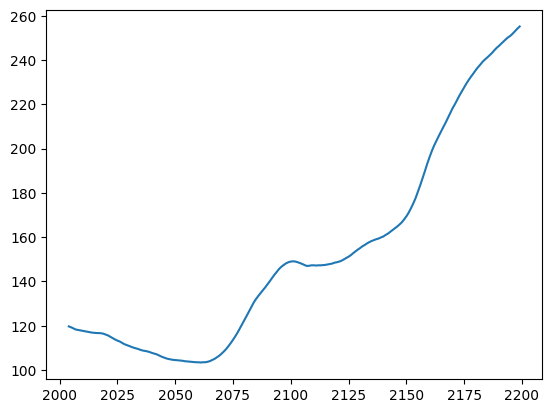

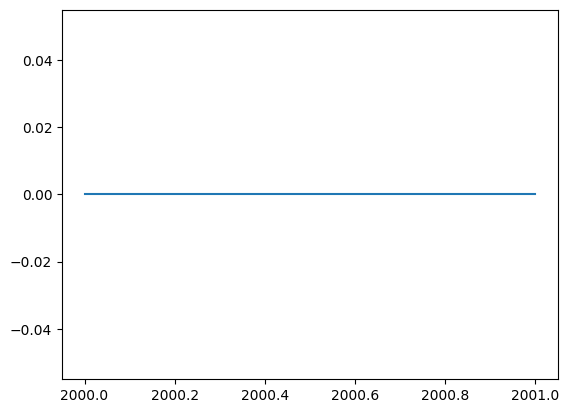

In [268]:
# Some variables should be treated in levels (like interest rates, or e.g. net foreign asset position)
# Others in dynamics (annual or quarterly), like GDP
# Yet others in deviations from trends, see below

example = df[(df['Country']=='SE')]
# example

cred_c, cred_t = sm.tsa.filters.hp_filter.hpfilter((example['Credit to GDP']), lamb=100_000)


cred_t_1s = np.zeros(len(cred_t))
cred_c_1s = np.zeros(len(cred_t))

# example['Credit to GDP'].iloc[:20]

cred_t_1s[0:2] = example['Credit to GDP'].iloc[0:2]

for i in range(2, len(cred_t)):
	temp_c, temp = sm.tsa.filters.hp_filter.hpfilter((100*np.log(example['Credit to GDP'].iloc[:i])), lamb=100_000)
	cred_t_1s[i] = np.exp(temp.iloc[-1]/100)
	cred_c_1s[i] = temp_c.iloc[-1]

fig, ax = plt.subplots()
example['Credit to GDP'].plot(ax=ax)
# cred_t.plot(ax=ax)
ax.plot(example.index, cred_t_1s)
plt.show()


plt.plot(example.index, cred_c_1s)
plt.show()

# # temp

# cred_t_1s

# sm.tsa.filters.hp_filter.hpfilter((example['Credit to GDP'].iloc[:2]))

In [272]:
df.isna().sum() #checking number of NA values

Country                                    0
Date                                       0
Dependent Variable                         0
Credit to GDP                            357
GDP growth                                 0
Inflation                                  4
3 month money market rate                559
Gross fixed capital formation to GDP       0
Account to GDP                          1061
10 Year Government Bond Rate             523
Unemployment                             596
International Investment                1561
Share Price Growth                         1
Housing Price Growth                       1
C-GDP/3MMR_dummy                           0
GDP/UER_dummy                              0
INF/10YGB_dummy                            0
GDP/SP_dummy                               0
C-GDP/UER_dummy                            0
Credit_HP_t                             2406
Credit_HP_c                             2408
dtype: int64

In [273]:
df.describe() #statistical info

,Dependent Variable,Credit to GDP,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,International Investment,Share Price Growth,Housing Price Growth,C-GDP/3MMR_dummy,GDP/UER_dummy,INF/10YGB_dummy,GDP/SP_dummy,C-GDP/UER_dummy,Credit_HP_t,Credit_HP_c
count,2600.000000,2243.000000,2600.000000,2596.000000,2041.000000,2600.000000,1539.000000,2077.000000,2004.000000,1.039000e+03,2599.000000,2599.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,194.000000,192.000000
mean,0.086538,147.619795,0.575281,4.565236,5.226277,0.613815,1.194811,5.836522,6.989920,-8.247209e+04,1.436099,0.962333,0.049231,0.083462,0.160769,0.261154,0.134615,118.902852,-1.179564
std,0.281212,46.682204,1.039398,4.825985,4.576821,4.675077,4.822940,3.608509,2.793479,1.627619e+06,10.567151,6.669869,0.216391,0.276632,0.367389,0.439348,0.341378,17.838567,2.942575
min,0.000000,57.400000,-6.477614,-2.200000,-0.776667,-47.053800,-12.853940,-0.544038,1.066667,-1.166644e+07,-99.377416,-98.224667,0.000000,0.000000,0.000000,0.000000,0.000000,85.600000,-6.269830
25%,0.000000,113.800000,0.072792,1.553091,1.255104,-0.899011,-1.971119,3.233500,5.000000,-2.375650e+05,-2.354326,0.037544,0.000000,0.000000,0.000000,0.000000,0.000000,104.732753,-3.406916
50%,0.000000,140.400000,0.595864,2.728318,4.263000,0.594571,0.360043,5.208667,6.966667,-5.274096e+04,1.562988,1.190135,0.000000,0.000000,0.000000,0.000000,0.000000,116.207905,-0.752941
75%,0.000000,171.000000,1.107636,6.273316,8.295667,2.128210,3.933131,8.423333,8.800000,1.321522e+05,6.438461,2.348737,0.000000,0.000000,0.000000,1.000000,0.000000,134.470388,0.531326
max,1.000000,294.300000,6.094493,46.239230,20.737500,161.146555,19.002730,17.073330,18.100000,3.682981e+06,51.582402,21.641567,1.000000,1.000000,1.000000,1.000000,1.000000,146.968848,4.848758


In [21]:
df_crisis = df[df['Dependent Variable'] == 1]
df_tranquil = df[df['Dependent Variable'] == 0]

# df_crisis

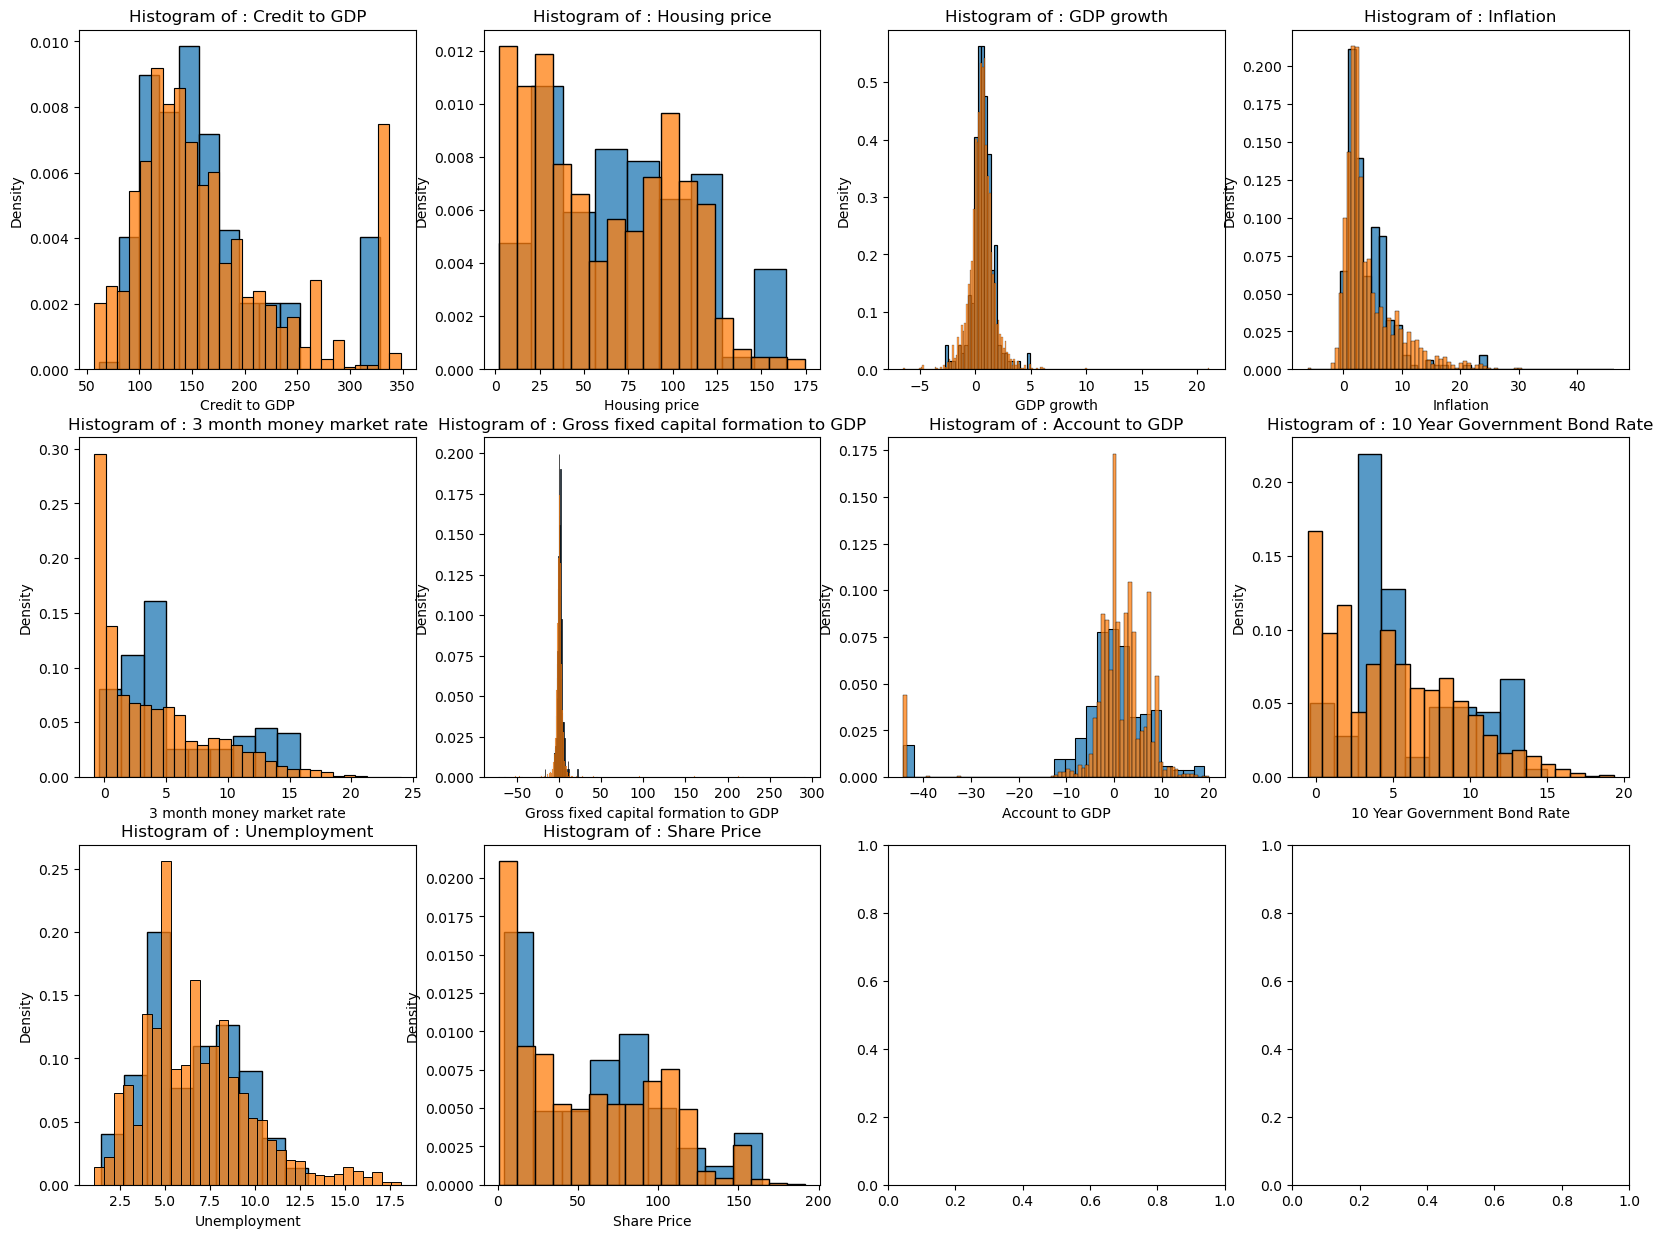

In [ ]:
# Be more consistent with dynamics and levels.
# Better yet, have all vars in both levels (where it makes sense) and dynamics (growth rates)

# Comment 2: as a pre-analysis step use df_crisis and df_tranquil to create variable interaction terms
# and then pick for later analysis those that have the most different distributions across datasets

# Nijat: not started yet

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
for i, ax in zip(df.columns[3:], axes.flat):
    sns.histplot(x=df_crisis[i], ax=ax, stat='density').set(title=f"Histogram of : {i}", xlabel="")
    sns.histplot(x=df_tranquil[i], ax=ax, color='C1', stat='density')
plt.show()

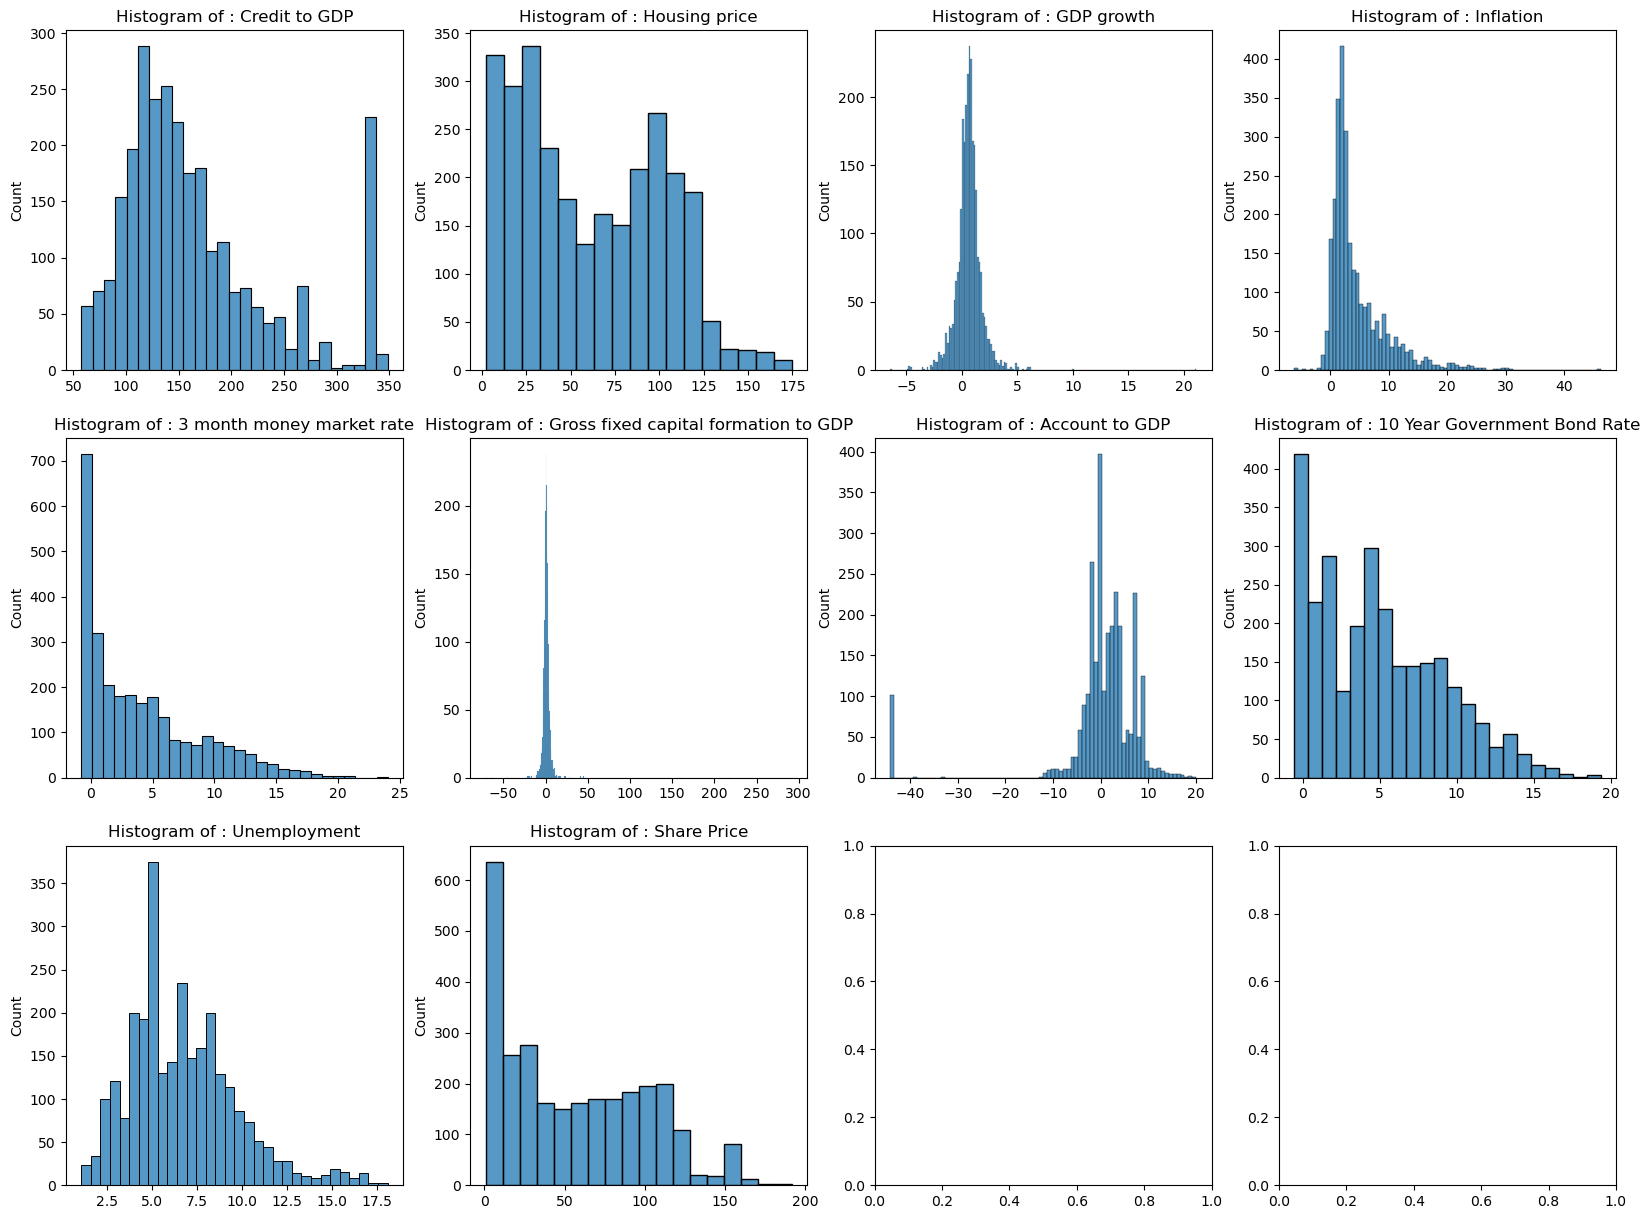

In [ ]:
# Be more consistent with dynamics and levels.
# Better yet, have all vars in both levels (where it makes sense) and dynamics (growth rates)

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
for i, ax in zip(df.columns[3:], axes.flat):
    sns.histplot(x=df[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

In [22]:
# Drop Ireland due to crazy data. Check if Netherlands data are correct
df[df['Gross fixed capital formation to GDP'] < -30]

,Country,Date,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,Share Price
1582,NL,2015-Q3,0,287.4,100.792756,0.34515,0.733358,-0.0278,-47.0538,6.754855,0.901667,7.733333,99.18419


In [23]:
# Drop Ireland due to crazy data
df[df['Gross fixed capital formation to GDP'] > 40]

,Country,Date,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,Share Price
1437,NL,1979-Q2,0,100.7,31.473624,5.824767,4.198996,NaN,41.361368,NaN,8.786667,NaN,8.523249
1581,NL,2015-Q2,0,286.1,99.452163,0.308193,0.880777,-0.006533,161.146555,-7.314887,0.707333,8.0,105.095700


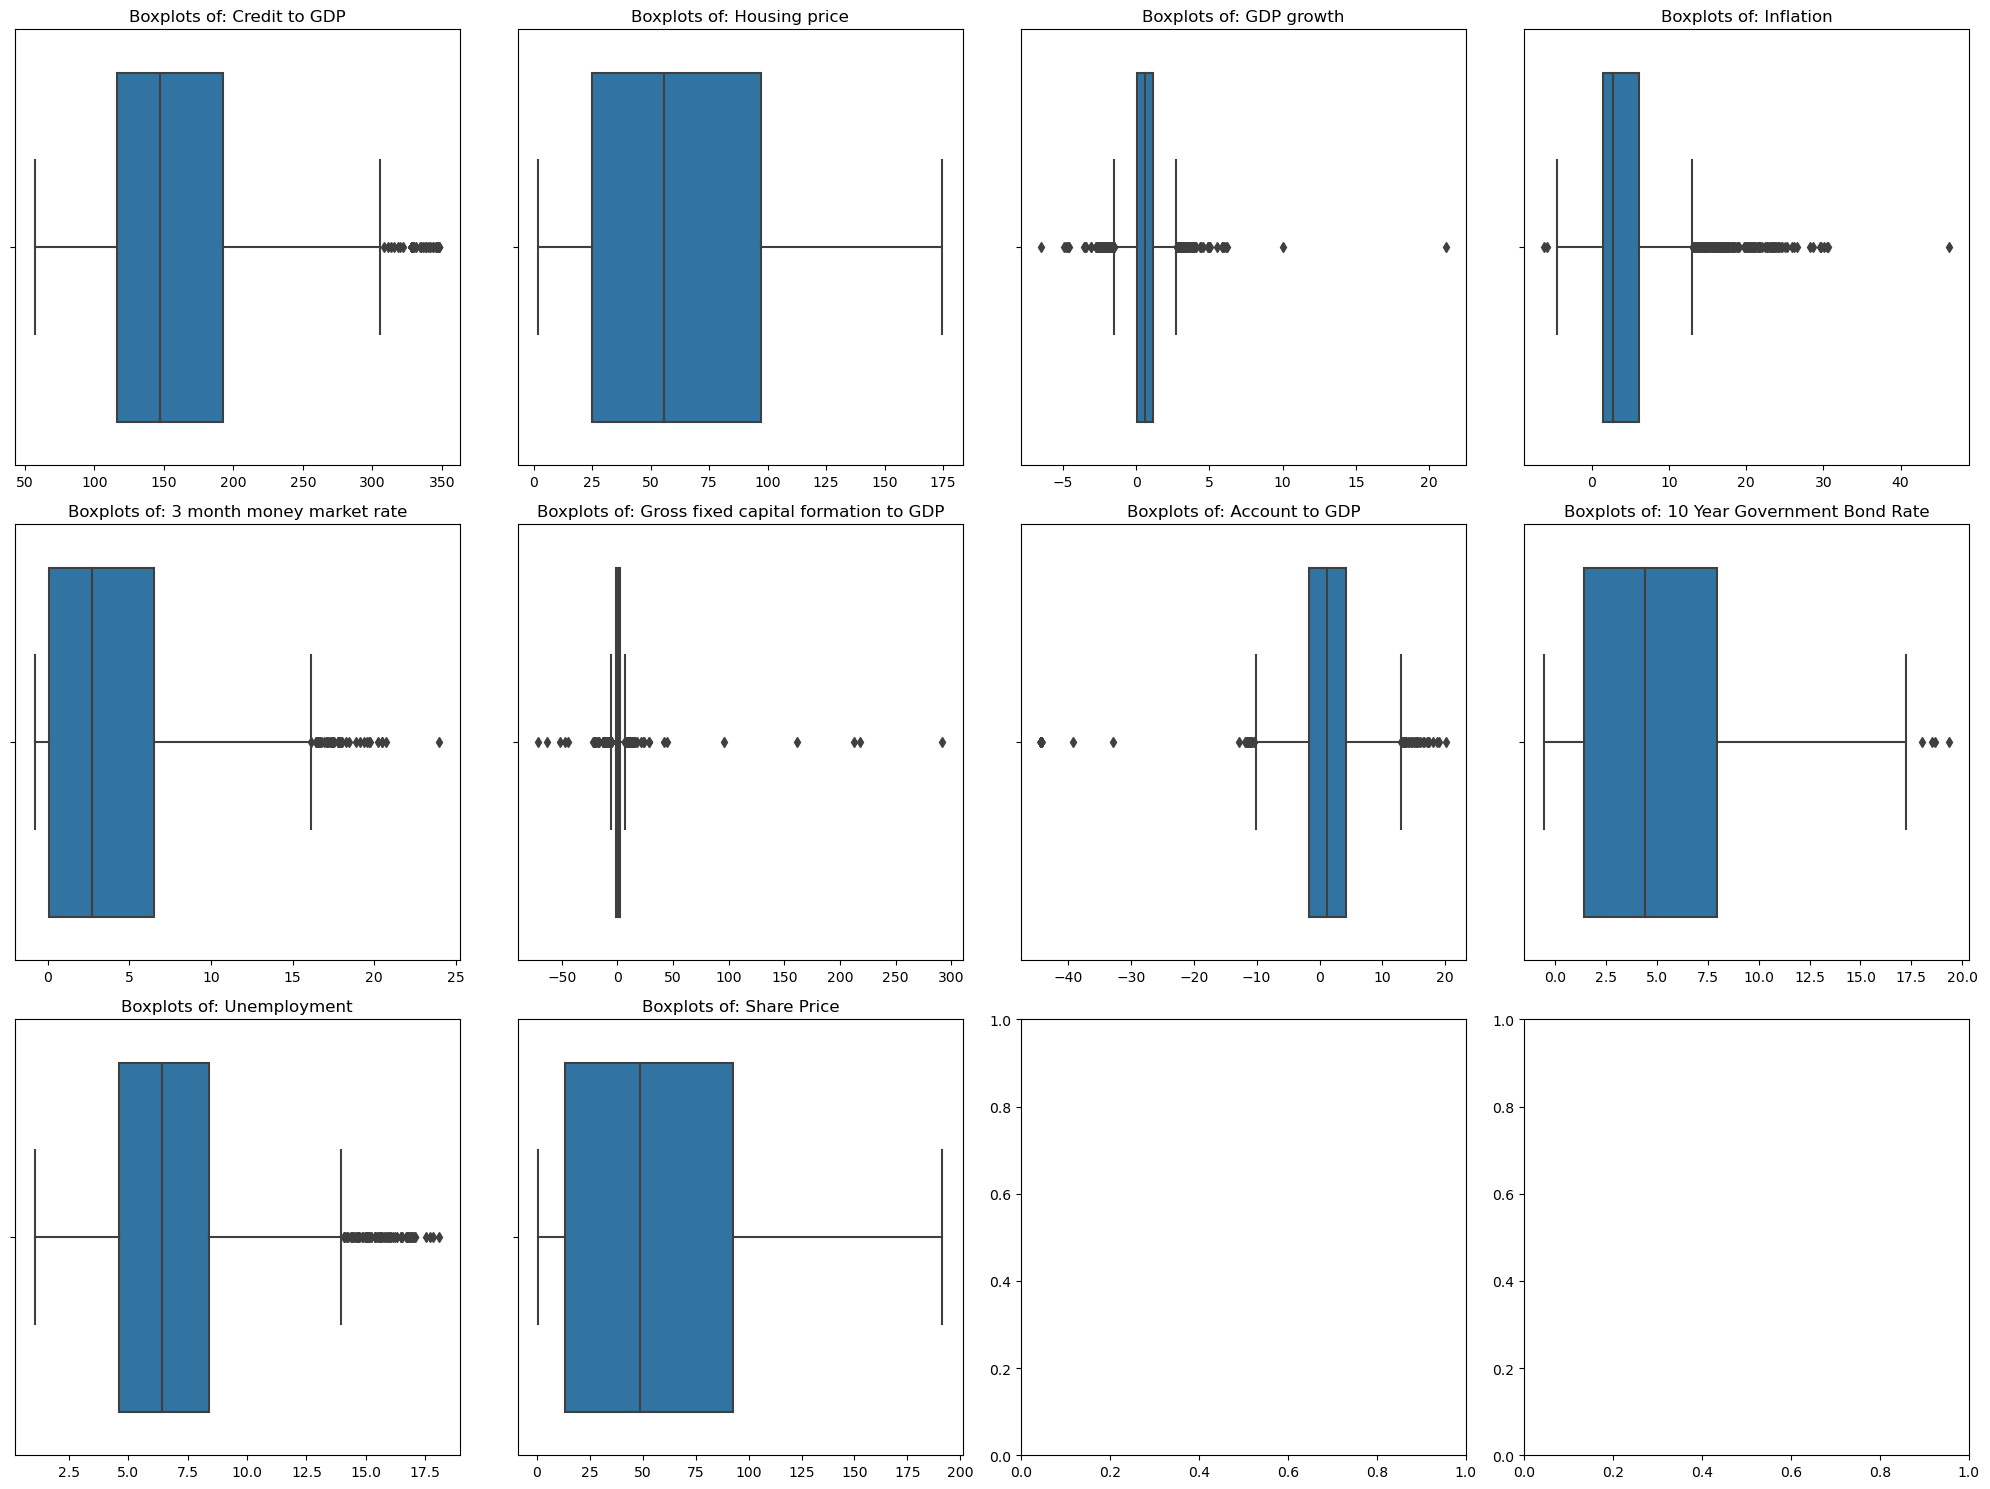

In [ ]:
numeric_columns = df.select_dtypes(include='number')

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))

for i, ax in zip(numeric_columns.columns[1:], axes.flat):
    sns.boxplot(x=numeric_columns[i], ax=ax, orient='h')
    ax.set(title=f"Boxplots of: {i}", xlabel="")

plt.tight_layout()
plt.show()

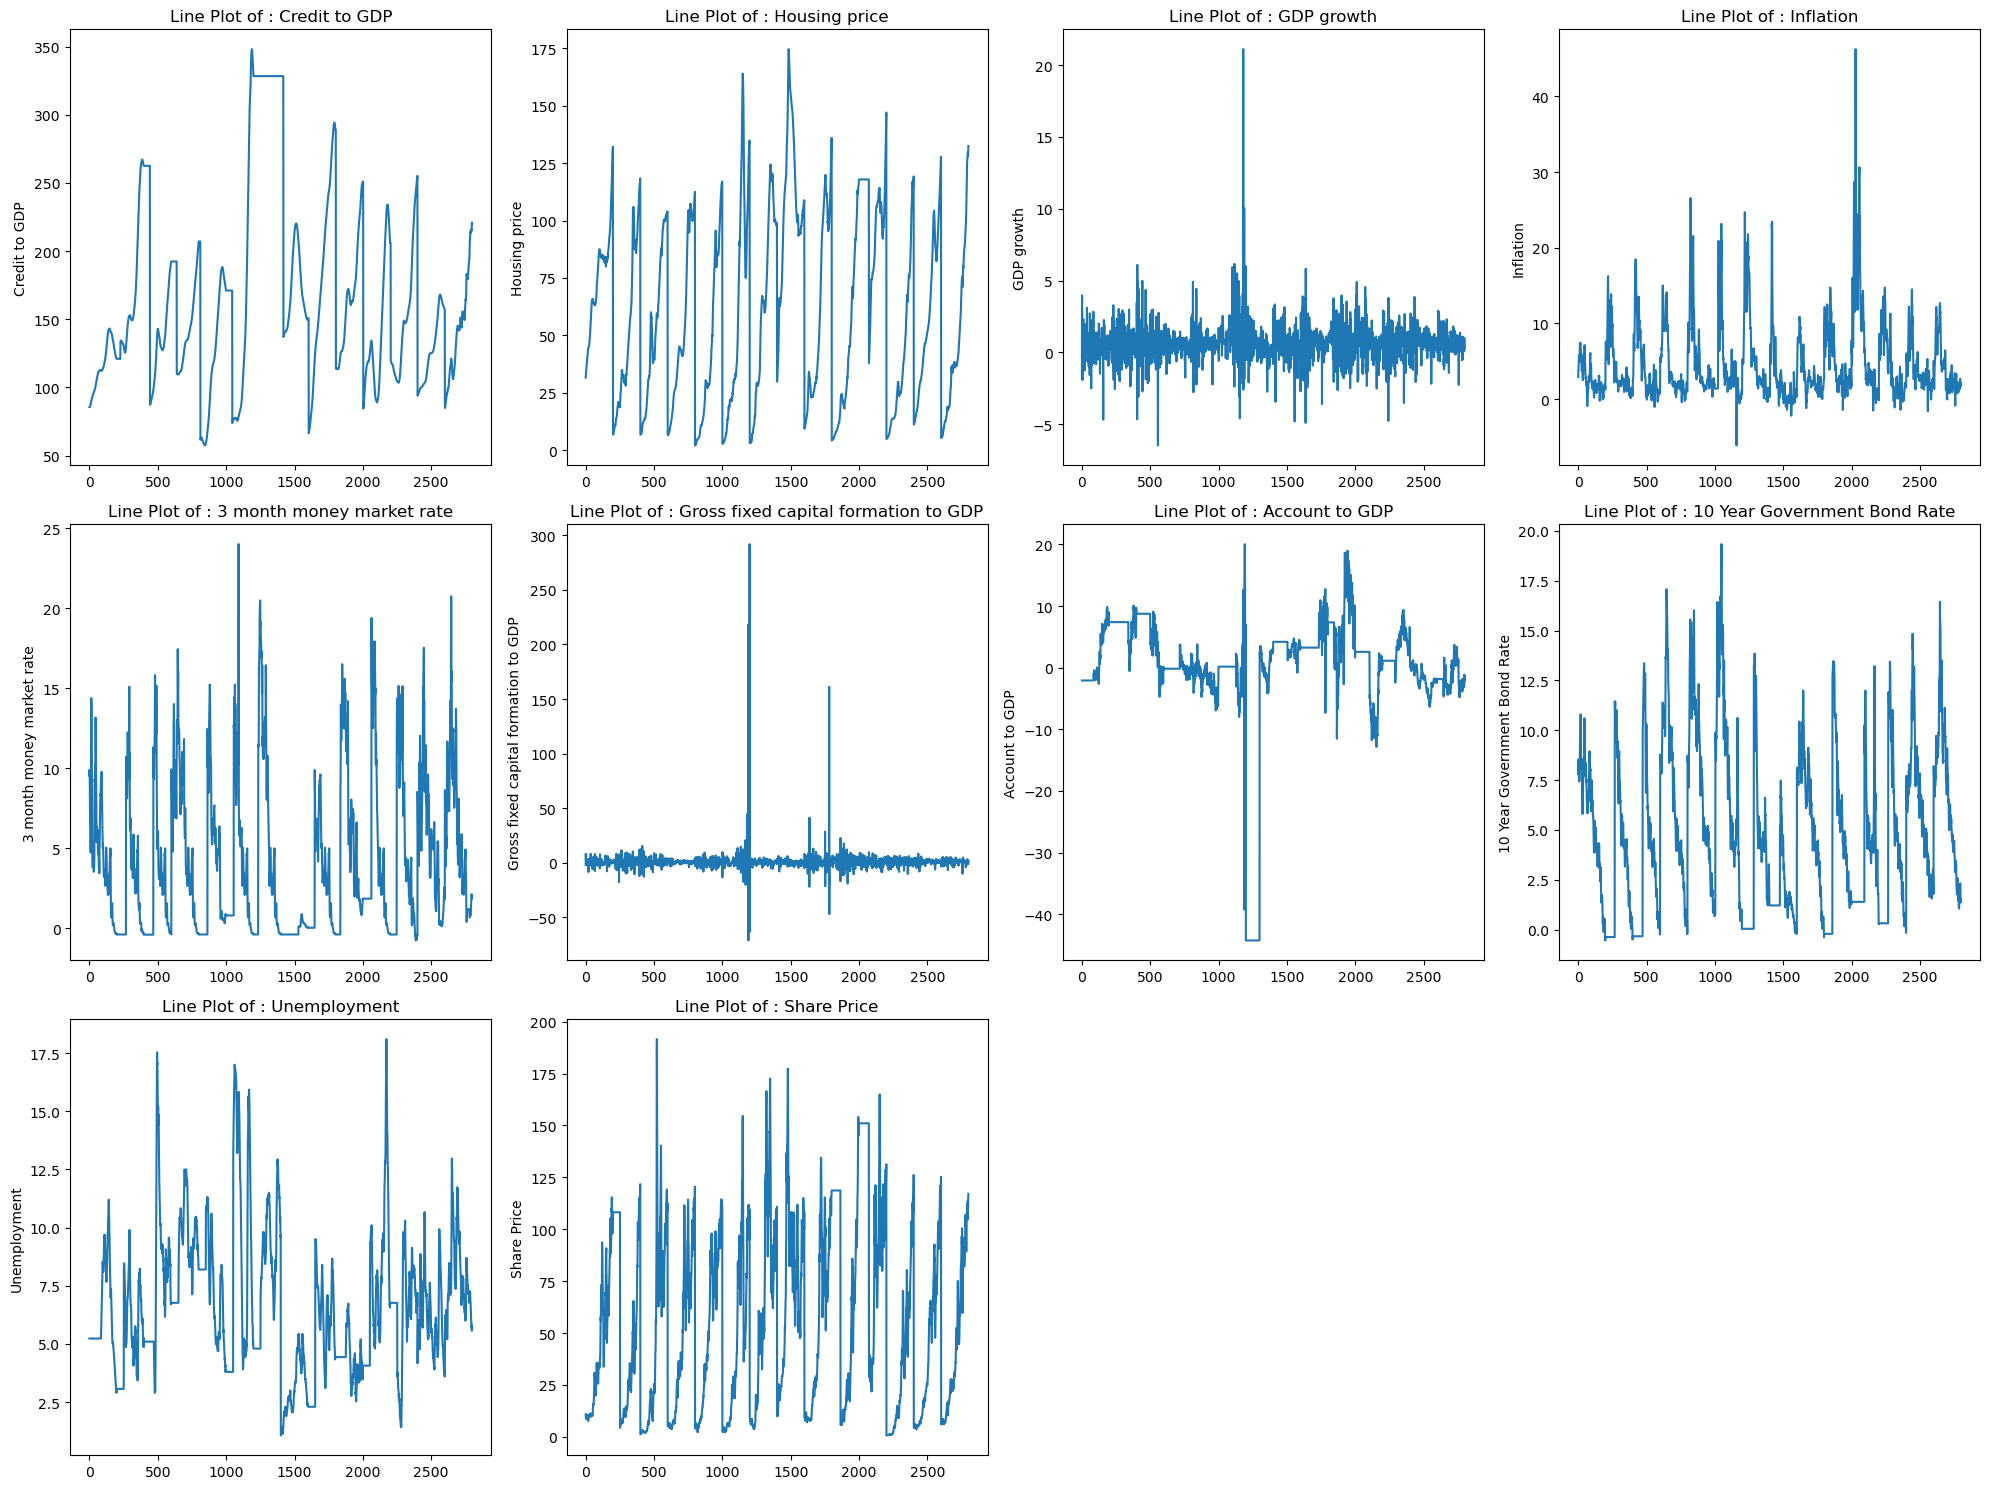

In [ ]:
num_variables = len(df.columns) - 3
num_plots = min(10, num_variables)
num_cols = 4
num_rows = (num_plots - 1) // num_cols + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(20, 15))

for i, ax in zip(df.columns[3:], axes.flat):
    sns.lineplot(data=df, x=df.index, y=df[i], ax=ax)
    ax.set(title=f"Line Plot of : {i}", xlabel="")

for i in range(num_plots, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

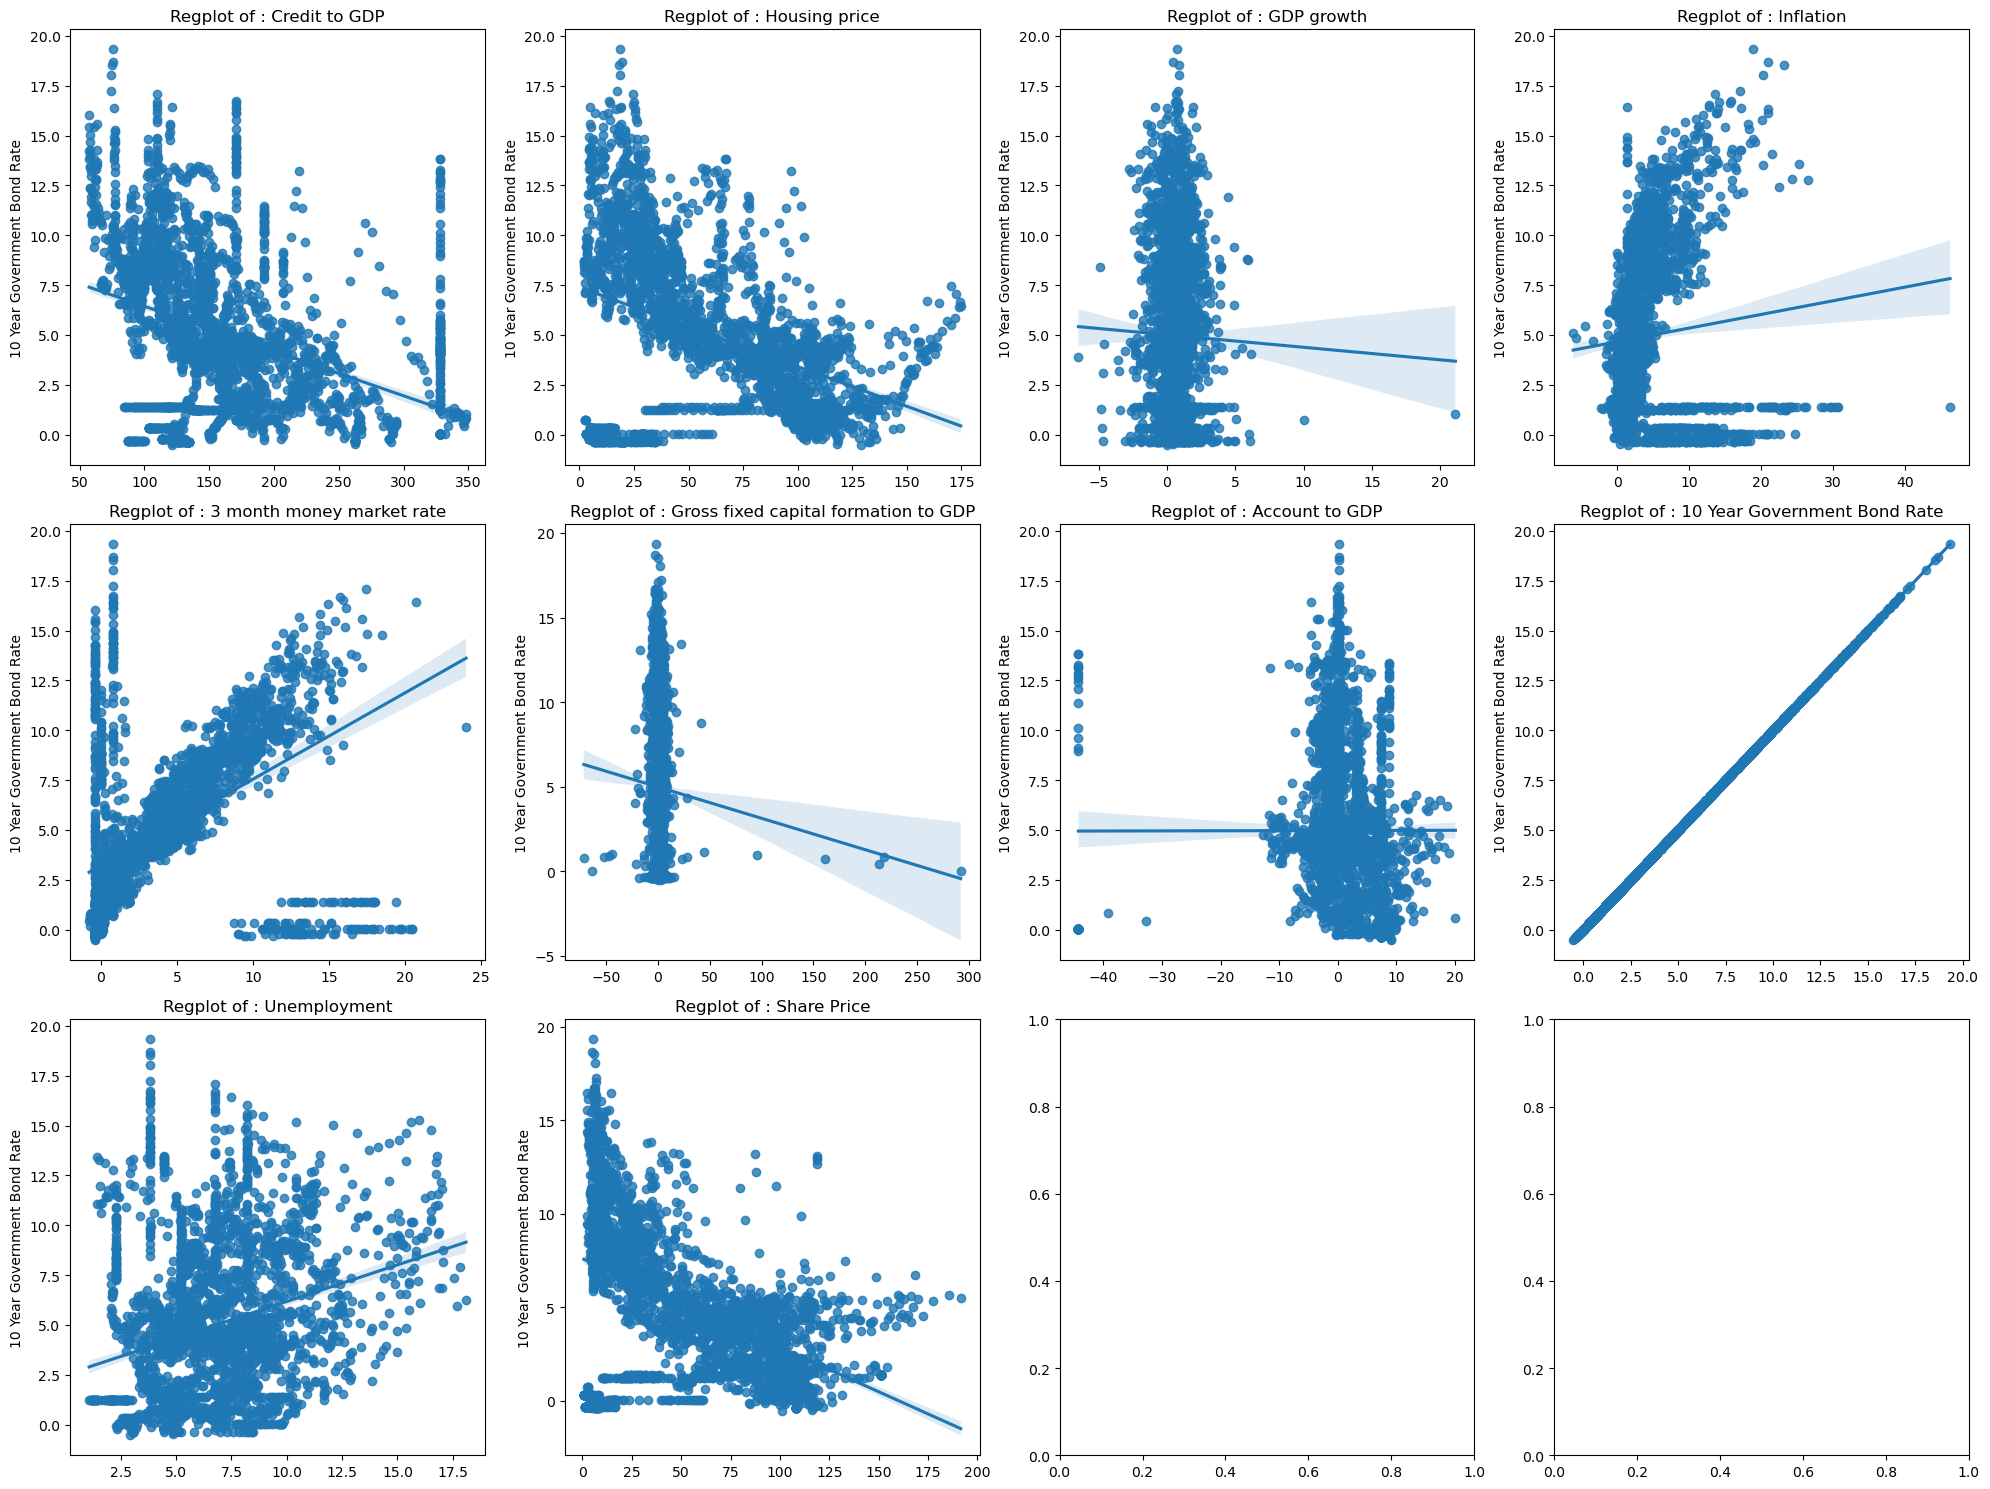

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))

for i, ax in zip(df.columns[3:], axes.flat):
    sns.regplot(x=df[i], y=df["10 Year Government Bond Rate"], ax=ax)
    ax.set(title=f"Regplot of : {i}", xlabel="")

plt.tight_layout()
plt.show()

C:\Users\Marcin\AppData\Local\Temp\ipykernel_26084\623160834.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


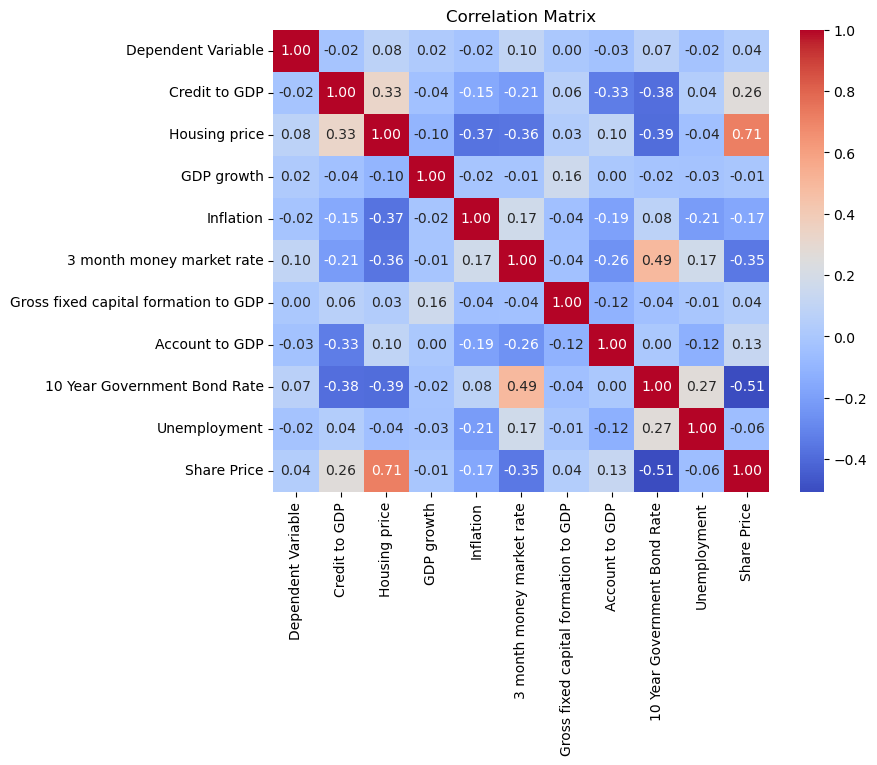

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# First try to normalize the "regular" dataset, i.e without unusual outliers, you might include them later if needed
# Nijat: not started yet
columns_to_normalize = df.columns[3:]
df_subset = df[columns_to_normalize]
scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_subset), columns=columns_to_normalize)
norm_df = pd.concat([df.iloc[:, :3], df_normalized], axis=1)

norm_df

,Country,Date,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,Share Price
0,DE,1970-Q1,0,-1.146417,-0.725996,-1.896584,-0.338422,1.190873,-0.296248,-0.231035,0.701649,-0.497536,-1.026028
1,DE,1970-Q2,0,-1.146417,-0.705453,2.870081,-0.247586,1.267644,0.750096,-0.231035,0.840561,-0.497536,-1.050506
2,DE,1970-Q3,0,-1.146417,-0.684571,1.066603,-0.200258,1.154659,0.457819,-0.231035,0.873246,-0.497536,-1.062812
3,DE,1970-Q4,0,-1.146417,-0.663269,0.193748,-0.111013,1.037329,-0.095040,-0.231035,0.865075,-0.497536,-1.072815
4,DE,1971-Q1,0,-1.143544,-0.642302,-2.175014,-0.020294,0.743279,-0.245103,-0.231035,0.685307,-0.497536,-1.052985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,CA,2018-Q4,0,0.729889,1.710129,-0.239790,-0.514966,-0.422221,-0.225041,-0.319119,-0.650360,-0.340747,1.130469
2796,CA,2019-Q1,0,0.741383,1.707554,-0.470882,-0.602144,-0.447116,0.072601,-0.335734,-0.763186,-0.307150,1.229333
2797,CA,2019-Q2,0,0.774426,1.670436,0.313955,-0.491777,-0.477259,-0.091605,-0.134197,-0.822325,-0.385544,1.346048
2798,CA,2019-Q3,0,0.798850,1.711954,-0.211422,-0.534767,-0.481973,0.134101,-0.242581,-0.884535,-0.329548,1.362352


In [ ]:
norm_df['Date'] = pd.to_datetime(norm_df['Date'])
norm_df.set_index(['Country', 'Date'], inplace=True)

Dependent Variable  Credit to GDP  Housing price  \
Country Date                                                           
DE      1970-01-01                   0      -1.146417      -0.725996   
        1970-04-01                   0      -1.146417      -0.705453   
        1970-07-01                   0      -1.146417      -0.684571   
        1970-10-01                   0      -1.146417      -0.663269   
        1971-01-01                   0      -1.143544      -0.642302   
...                                ...            ...            ...   
CA      2018-10-01                   0       0.729889       1.710129   
        2019-01-01                   0       0.741383       1.707554   
        2019-04-01                   0       0.774426       1.670436   
        2019-07-01                   0       0.798850       1.711954   
        2019-10-01                   0       0.785920       1.780340   

                    GDP growth  Inflation  3 month money market rate  \
Country Date                                                           
DE      1970-01-01   -1.896584  -0.338422                   1.190873   
        1970-04-01    2.870081  -0.247586                   1.267644   
        1970-07-01    1.066603  -0.200258                   1.154659   
        1970-10-01    0.193748  -0.111013                   1.037329   
        1971-01-01   -2.175014  -0.020294                   0.743279   
...                        ...        ...                        ...   
CA      2018-10-01   -0.239790  -0.514966                  -0.422221   
        2019-01-01   -0.470882  -0.602144                  -0.447116   
        2019-04-01    0.313955  -0.491777                  -0.477259   
        2019-07-01   -0.211422  -0.534767                  -0.481973   
        2019-10-01   -0.251768  -0.502805                  -0.475707   

                    Gross fixed capital formation to GDP  Account to GDP  \
Country Date                                                               
DE      1970-01-01                             -0.296248       -0.231035   
        1970-04-01                              0.750096       -0.231035   
        1970-07-01                              0.457819       -0.231035   
        1970-10-01                             -0.095040       -0.231035   
        1971-01-01                             -0.245103       -0.231035   
...                                                  ...             ...   
CA      2018-10-01                             -0.225041       -0.319119   
        2019-01-01                              0.072601       -0.335734   
        2019-04-01                             -0.091605       -0.134197   
        2019-07-01                              0.134101       -0.242581   
        2019-10-01                             -0.178843       -0.167699   

                    10 Year Government Bond Rate  Unemployment  Share Price  \
Country Date                                                                  
DE      1970-01-01                      0.701649     -0.497536    -1.026028   
        1970-04-01                      0.840561     -0.497536    -1.050506   
        1970-07-01                      0.873246     -0.497536    -1.062812   
        1970-10-01                      0.865075     -0.497536    -1.072815   
        1971-01-01                      0.685307     -0.497536    -1.052985   
...                                          ...           ...          ...   
CA      2018-10-01                     -0.650360     -0.340747     1.130469   
        2019-01-01                     -0.763186     -0.307150     1.229333   
        2019-04-01                     -0.822325     -0.385544     1.346048   
        2019-07-01                     -0.884535     -0.329548     1.362352   
        2019-10-01                     -0.846520     -0.340747     1.412466   

                    interact_dummy  
Country Date                        
DE      1970-01-01               0  
        1970-04-01

In [ ]:
X = norm_df.drop('Dependent Variable', axis=1)
y = norm_df['Dependent Variable']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=123).fit(X_train, y_train)

In [ ]:
feature_names = norm_df.drop('Dependent Variable', axis=1)
coefficients = lr.coef_[0]
std_errors = np.std(X, 0) * np.sqrt((1 -  lr.score(X_train, y_train)) / (lr.score(X_train, y_train) * len(y_train)))

z_scores = coefficients / std_errors

p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_scores]

for feature, coef, z, p in zip(feature_names, coefficients, z_scores, p_values):
    print(f"{feature}: Coefficient = {coef:.4f}, Z-score = {z:.4f}, P-value = {p:.4f}")

Credit to GDP: Coefficient = -0.1106, Z-score = -17.0401, P-value = 0.0000
Housing price: Coefficient = 0.5819, Z-score = 89.6859, P-value = 0.0000
GDP growth: Coefficient = 0.1195, Z-score = 18.4191, P-value = 0.0000
Inflation: Coefficient = -0.1094, Z-score = -16.8595, P-value = 0.0000
3 month money market rate: Coefficient = 0.4158, Z-score = 64.0909, P-value = 0.0000
Gross fixed capital formation to GDP: Coefficient = -0.0239, Z-score = -3.6810, P-value = 0.0002
Account to GDP: Coefficient = -0.2049, Z-score = -31.5770, P-value = 0.0000
10 Year Government Bond Rate: Coefficient = 0.3587, Z-score = 55.2841, P-value = 0.0000
Unemployment: Coefficient = -0.2185, Z-score = -33.6807, P-value = 0.0000
Share Price: Coefficient = 0.0724, Z-score = 11.1551, P-value = 0.0000
interact_dummy: Coefficient = -0.2309, Z-score = -130.9050, P-value = 0.0000


In [ ]:
intercept = lr.intercept_[0]

# Calculate the standard error of the intercept
std_error_intercept = np.sqrt((1 - lr.score(X_train, y_train)) / (lr.score(X_train, y_train) * len(y_train)))

# Calculate the z-score for the intercept
z_score_intercept = intercept / std_error_intercept

# Calculate the two-tailed p-value for the intercept
p_value_intercept = 2 * (1 - norm.cdf(np.abs(z_score_intercept)))

# Print the intercept, z-score, and p-value for the intercept
print(f"Intercept: {intercept:.4f}, Z-score = {z_score_intercept:.4f}, P-value = {p_value_intercept:.4f}")

Intercept: -2.5415, Z-score = -391.7420, P-value = 0.0000


In [ ]:
num_folds = 10
y_trainr = np.ravel(y_train)

cross_val_scores = cross_val_score(lr, X_train, y_trainr, cv=num_folds, scoring='accuracy')


for fold, score in enumerate(cross_val_scores, start=1):
    print(f"Fold {fold}: {score:.4f}")

mean_score = cross_val_scores.mean()
std_deviation = cross_val_scores.std()
print(f"Mean Accuracy: {mean_score:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")

Fold 1: 0.9152
Fold 2: 0.9152
Fold 3: 0.9152
Fold 4: 0.9152
Fold 5: 0.9152
Fold 6: 0.9152
Fold 7: 0.9152
Fold 8: 0.9107
Fold 9: 0.9107
Fold 10: 0.9062
Mean Accuracy: 0.9134
Standard Deviation: 0.0030


In [ ]:
threshold = 0.1
y_probs_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = np.where(y_probs_lr >= threshold, 1, 0)

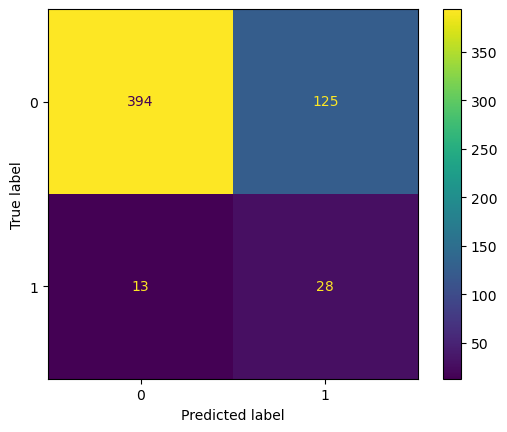

In [ ]:
confusion_matrix_lr = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lr, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.7535714285714286

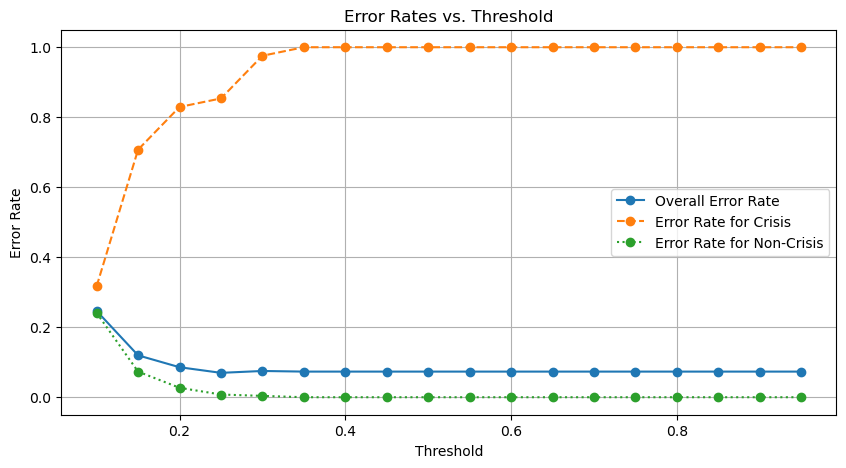

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm

# Train the logistic regression model (replace with your data)
model = LogisticRegression()
result = model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_lr.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulnesssd
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.04321428571428571
Absolute Usefulness: 0.02267857142857143
Relative Usefulness: 0.3441734417344174


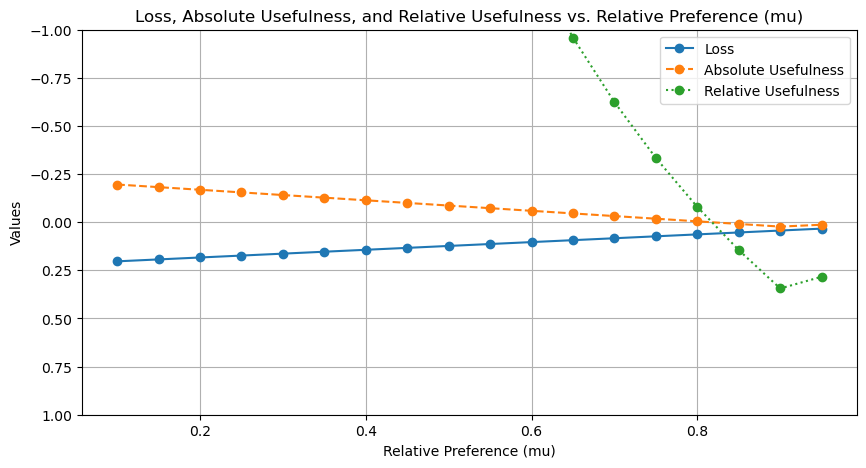

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_lr.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

## LASSO

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]  # Adjust the balance between L1 and L2 regularization for Elastic Net
}

# Create a Logistic Regression model
logistic = LogisticRegression(solver='saga', max_iter=1000)

# Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(logistic, param_grid, cv=10, scoring='accuracy', verbose=1)

# Fit the model and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters for Logistic Regression:", grid_search.best_params_)
print("Best accuracy score for Logistic Regression:", grid_search.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib

c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Marcin\miniconda3\lib

Best hyperparameters for Logistic Regression: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best accuracy score for Logistic Regression: 0.9138392857142857


c:\Users\Marcin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
lasso = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=1000, random_state=123)
lasso.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', random_state=123,
                   solver='saga')

In [ ]:
threshold = 0.175
y_probs_lasso = lasso.predict_proba(X_test)[:, 1]
y_pred_lasso = np.where(y_probs_lasso >= threshold, 1, 0)

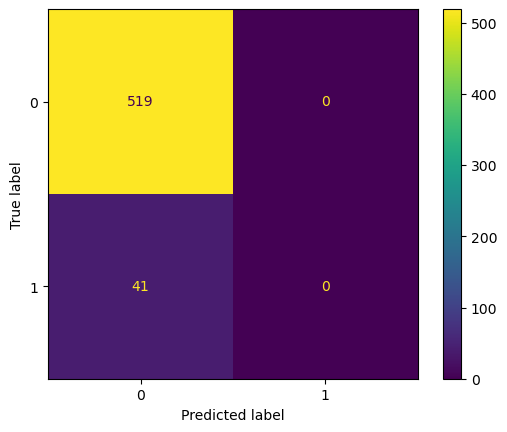

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_lasso = confusion_matrix(y_test, y_pred_lasso)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lasso, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_lasso)

0.9267857142857143

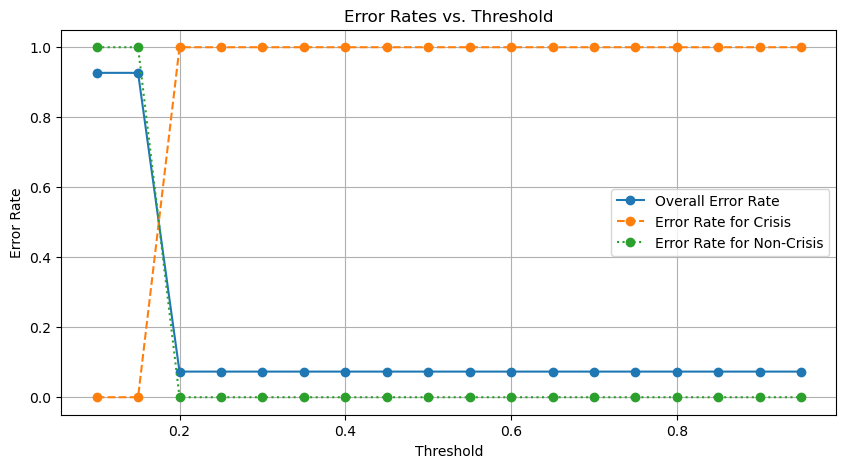

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = lasso  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_lasso.ravel()

# Define mu and class probabilities
mu = 0.6  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.04392857142857143
Absolute Usefulness: 0.0
Relative Usefulness: 0.0


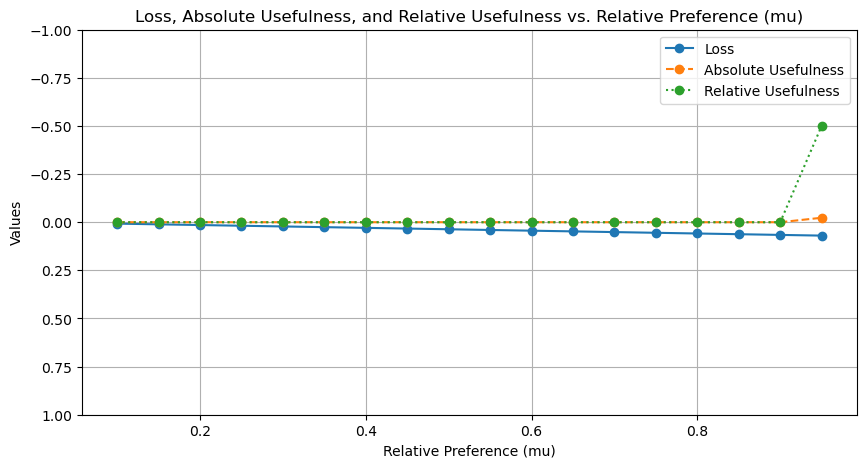

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_lasso.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a GridSearchCV object
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the model to your data (replace X_train and y_train with your data)
knn_grid.fit(X_train, y_train)

# Get the best hyperparameters and score
best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

print("Best hyperparameters for KNN:", best_knn_params)
print("Best accuracy score for KNN:", best_knn_score)


Best hyperparameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best accuracy score for KNN: 0.9522321428571429


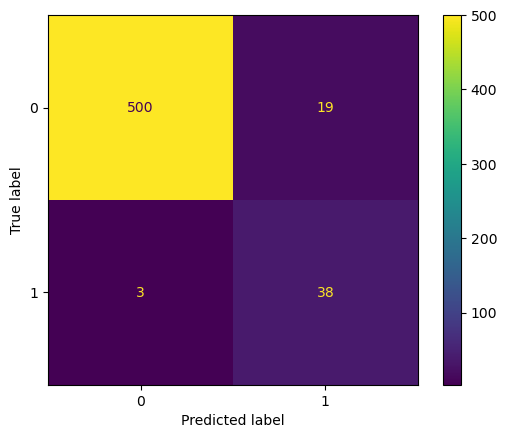

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 3, p= 1, weights='distance')
knn.fit(X_train, y_train)

threshold = 0.35
y_probs_knn = knn.predict_proba(X_test)[:, 1]
y_pred_knn = np.where(y_probs_knn >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_knn)

0.9607142857142857

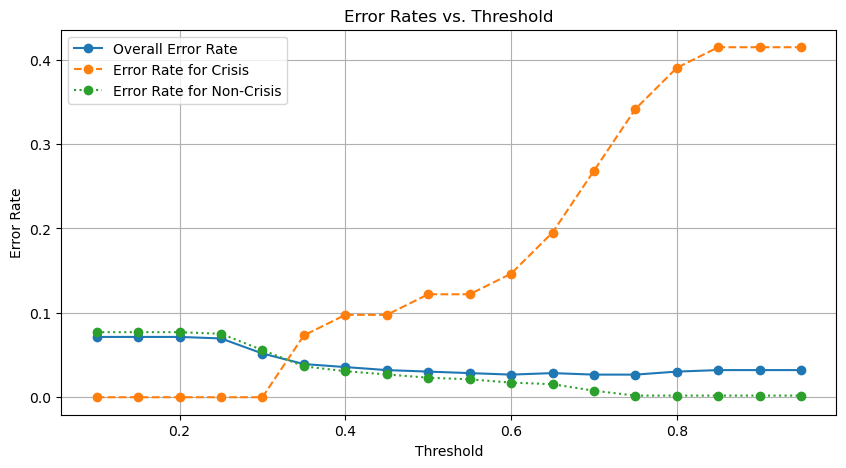

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = knn  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_knn.ravel()

# Define mu and class probabilities
mu = 0.9 # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.008214285714285714
Absolute Usefulness: 0.057678571428571426
Relative Usefulness: 0.8753387533875339


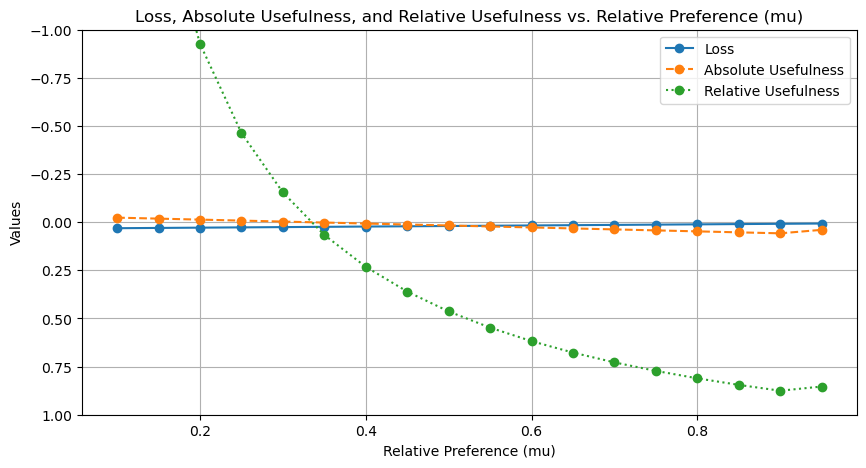

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_knn.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### SVM

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create an SVM classifier
svm = SVC()

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
}

# Create a GridSearchCV object
svm_grid = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')

# Fit the model to your data (replace X_train and y_train with your data)
svm_grid.fit(X_train, y_train)

# Get the best hyperparameters and score
best_svm_params = svm_grid.best_params_
best_svm_score = svm_grid.best_score_

print("Best hyperparameters for SVM:", best_svm_params)
print("Best accuracy score for SVM:", best_svm_score)


Best hyperparameters for SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy score for SVM: 0.9522321428571429
CPU times: total: 7min 31s
Wall time: 7min 33s


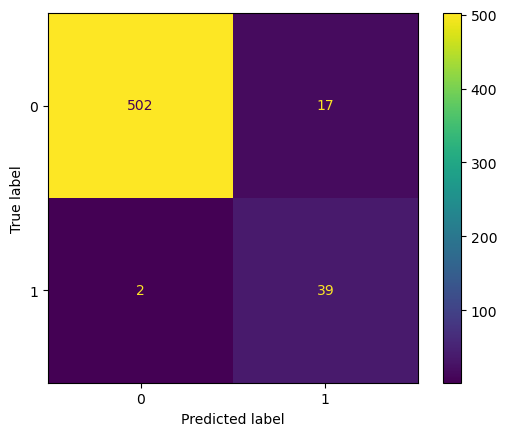

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=10, gamma=1, kernel='rbf', probability=True, random_state=39)
svm.fit(X_train, y_train)

threshold = 0.15
y_probs_svm = svm.predict_proba(X_test)[:, 1]
y_pred_svm = np.where(y_probs_svm >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=[0, 1])
cm_display.plot()
plt.show()


In [ ]:
accuracy_score(y_test, y_pred_svm)

0.9660714285714286

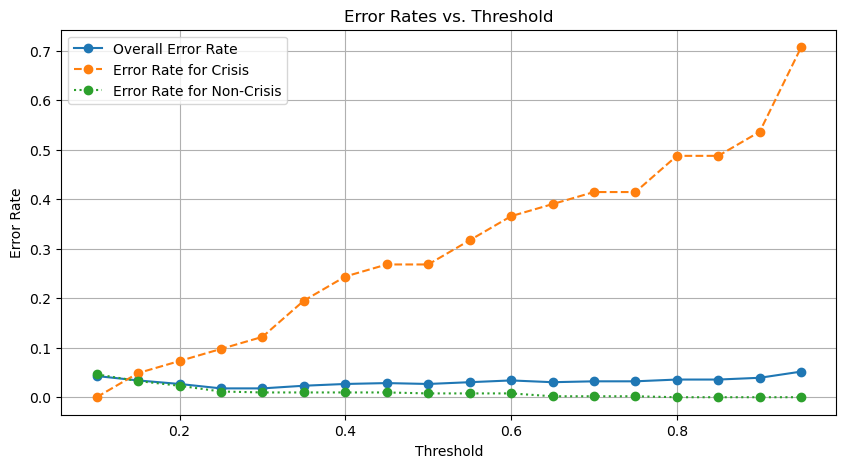

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = svm  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_svm.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.00625
Absolute Usefulness: 0.05964285714285714
Relative Usefulness: 0.9051490514905149


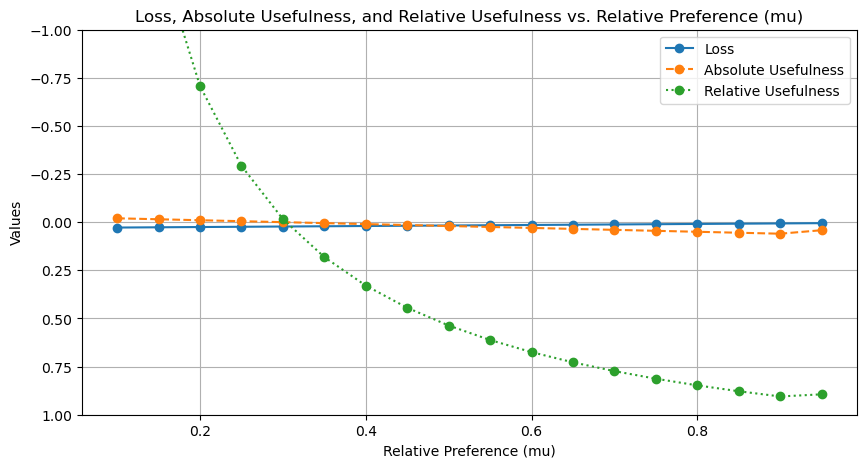

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_svm.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### DECISION TREE

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
dt_grid = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy')

# Fit the model to your data (replace X_train and y_train with your data)
dt_grid.fit(X_train, y_train)

# Get the best hyperparameters and score
best_dt_params = dt_grid.best_params_
best_dt_score = dt_grid.best_score_

print("Best hyperparameters for Decision Tree:", best_dt_params)
print("Best accuracy score for Decision Tree:", best_dt_score)


Best hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score for Decision Tree: 0.9535714285714285


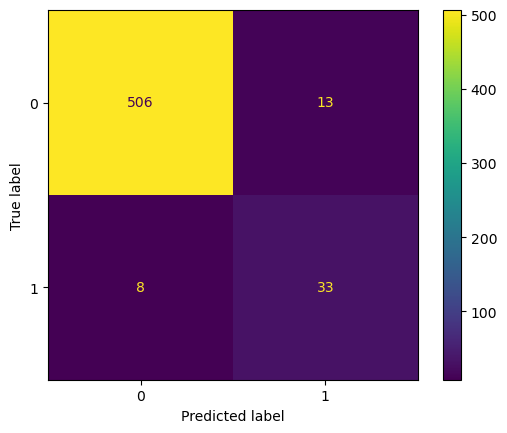

In [ ]:
dt = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf=1, min_samples_split=2, random_state=123)
dt.fit(X_train, y_train)

threshold = 0.2
y_probs_dt = dt.predict_proba(X_test)[:, 1]
y_pred_dt = np.where(y_probs_dt >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_dt)

0.9625

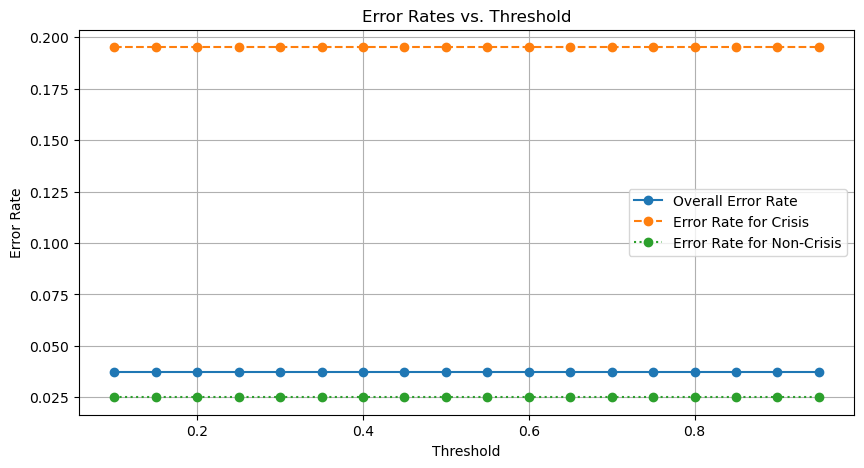

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = dt  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_dt.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.01517857142857143
Absolute Usefulness: 0.05071428571428571
Relative Usefulness: 0.7696476964769647


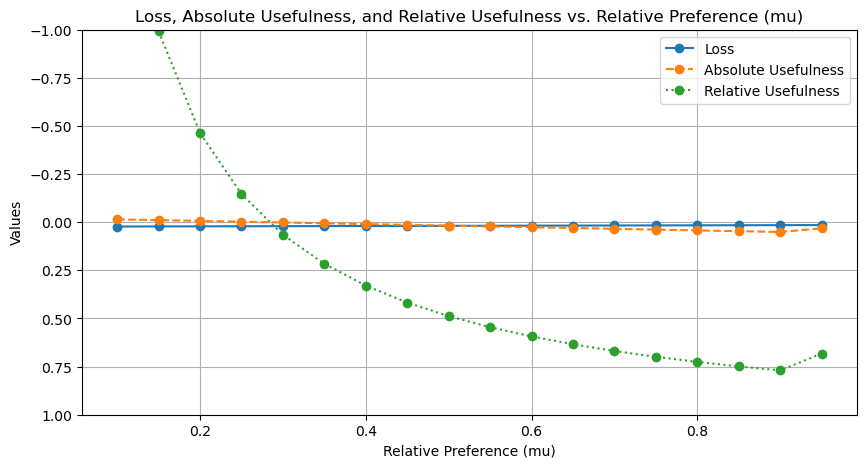

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_dt.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### RANDOM FOREST

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

# Fit the model to your data (replace X_train and y_train with your data)
rf_grid.fit(X_train, y_train)

# Get the best hyperparameters and score
best_rf_params = rf_grid.best_params_
best_rf_score = rf_grid.best_score_

print("Best hyperparameters for Random Forest:", best_rf_params)
print("Best accuracy score for Random Forest:", best_rf_score)


KeyboardInterrupt: 

In [ ]:
rf = RandomForestClassifier(criterion= 'entropy', max_depth= 20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=26)
rf.fit(X_train, y_train)

threshold = 0.15
y_probs_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = np.where(y_probs_rf >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_rf)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = rf  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_rf.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_rf.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

## Now we add completely external dataset that belongs to Spain, same variables but data completely is different and without any training we have tried to use models that previously trained with first dataset

In [ ]:
real = df = pd.read_excel("Spain Data.xlsx")

In [ ]:
real

In [ ]:
real.ffill(inplace=True)
real.bfill(inplace=True)
real

In [ ]:
real.describe()

In [ ]:
real.isna().sum()

In [ ]:
columns_to_normalize = real.columns[2:]

# Create a subset of the DataFrame with the selected columns
real_subset = real[columns_to_normalize]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the selected columns
df_normalized = pd.DataFrame(scaler.fit_transform(real_subset), columns=columns_to_normalize)

# Concatenate the non-normalized columns from the original DataFrame
norm_real = pd.concat([real.iloc[:, :2], df_normalized], axis=1)

norm_real

In [ ]:
norm_real['Date'] = pd.to_datetime(norm_real['Date'])
norm_real.set_index('Date', inplace=True)

In [ ]:
X_test_real = norm_real.drop('Dependent Variable', axis=1)
y_test_real = norm_real['Dependent Variable']

### LOGISTIC REGRESSION (SPAIN)

In [ ]:
lr_real = LogisticRegression(random_state=107).fit(X_train, y_train)

In [ ]:
threshold = 0.2
y_probs_lr_real = lr_real.predict_proba(X_test_real)[:, 1]
y_pred_lr_real = np.where(y_probs_lr_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_lr_real = confusion_matrix(y_test_real, y_pred_lr_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_lr_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = lr_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_lr_real.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_lr_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### LASSO (SPAIN)

In [ ]:
lasso_real = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=1000, random_state=107)
lasso_real.fit(X_train, y_train)

In [ ]:
# Is the number of observations correct? Check

threshold = 0.2
y_probs_lasso_real = lasso_real.predict_proba(X_test_real)[:, 1]
y_pred_lasso_real = np.where(y_probs_lasso_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_lasso_real = confusion_matrix(y_test_real, y_pred_lasso_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lasso_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_lasso_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = lasso_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_lasso_real.ravel()

# Define mu and class probabilities
mu = 0.6  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_lasso_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### KNN (SPAIN)

In [ ]:
knn_real = KNeighborsClassifier(n_neighbors= 3, p= 1, weights='distance')
knn_real.fit(X_train, y_train)

In [ ]:
threshold = 0.4
y_probs_knn_real = knn_real.predict_proba(X_test_real)[:, 1]
y_pred_knn_real = np.where(y_probs_knn_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_knn_real = confusion_matrix(y_test_real, y_pred_knn_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_knn_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = knn_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_knn_real.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_knn_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### SVM (SPAIN)

In [ ]:
svm_real = SVC(C=10, gamma=1, kernel='rbf', probability=True, random_state=159)
svm_real.fit(X_train, y_train)

In [ ]:
threshold = 0.1

y_probs_svm_real = svm.predict_proba(X_test_real)[:, 1]
y_pred_svm_real = np.where(y_probs_svm_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_svm_real = confusion_matrix(y_test_real, y_pred_svm_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_svm_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = svm_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_svm_real.ravel()

# Define mu and class probabilities
mu = 0.6  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_svm_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### DECISION TREE (SPAIN)

In [ ]:
dt_real = DecisionTreeClassifier(criterion= 'gini', max_depth= 20, min_samples_leaf=1,
                            min_samples_split=2, random_state=20)
dt_real.fit(X_train, y_train)

In [ ]:
threshold = 0.2
y_probs_dt_real = dt_real.predict_proba(X_test_real)[:, 1]
y_pred_dt_real = np.where(y_probs_dt_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_dt_real = confusion_matrix(y_test_real, y_pred_dt_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_dt_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = dt_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_dt_real.ravel()

# Define mu and class probabilities
mu = 0.6  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_dt_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()

### RANDOM FOREST (SPAIN)

In [ ]:
rf_real = RandomForestClassifier(criterion= 'entropy',
                                 max_depth= 20, min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=100, random_state=123)
rf_real.fit(X_train, y_train)

In [ ]:
threshold = 0.1

y_probs_rf_real = rf_real.predict_proba(X_test_real)[:, 1]
y_pred_rf_real = np.where(y_probs_rf_real >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_rf_real = confusion_matrix(y_test_real, y_pred_rf_real)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_real, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
accuracy_score(y_test_real, y_pred_rf_real)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

# Replace 'LogisticRegression()' with your specific model using the best hyperparameters
model = rf_real  # Assuming 'best_lr' is your model from earlier

# Fit the model to your training data (if not already done)
model.fit(X_train, y_train)

# Get predicted probabilities for class 1
predicted_probabilities = model.predict_proba(X_test_real)[:, 1]

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store error rates
overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

# Calculate error rates for each threshold
for threshold in thresholds:
    # Assign labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    # Calculate the confusion matrix
    confusion = cm(y_test_real, predicted_labels)

    # Calculate error rates
    overall_error_rate = 1 - accuracy_score(y_test_real, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  # False negatives among defaulting customers
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  # False positives among non-defaulting customers

    # Append error rates to the lists
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion_matrix_rf_real.ravel()

# Define mu and class probabilities
mu = 0.9  # Relative preference between missing crises and false alarms
P1 = (TP + FN) / len(y_test)  # Probability of crises class
P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

# Calculate T1 and T2 from the confusion matrix
T1 = FN / (TP + FN)  # Type I errors (missed crises)
T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

# Compute the loss function
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

# Compute the absolute usefulness
min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

# Compute the relative usefulness
max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

# Define a range of mu (relative preference) values
mu_values = np.arange(0.1, 1.0, 0.05)

# Initialize lists to store Loss, Absolute Usefulness, and Relative Usefulness
loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_rf_real.ravel()

    # Define class probabilities
    P1 = (TP + FN) / len(y_test)  # Probability of crises class
    P2 = (TN + FP) / len(y_test)  # Probability of tranquil class

    # Calculate T1 and T2 from the confusion matrix
    T1 = FN / (TP + FN)  # Type I errors (missed crises)
    T2 = FP / (TN + FP)  # Type II errors (issued false alarms)

    # Compute the loss function
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    # Compute the absolute usefulness
    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    # Compute the relative usefulness
    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    # Append values to the lists
    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

# Create the figure
plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  # Set the y-axis limits to range from 1 to -1
plt.grid(True)
plt.legend()
plt.show()